# Introduction to Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

To start, we'll use synthetic data which is generated by the function $y = \sin(2\pi x_1) + \cos(2\pi x_2) + \epsilon$ where $x \sim N(0, 0.2)$.

In [2]:
def generateData(size = 50, sigma = 0.2, random_state = None):
    if random_state:
        np.random.seed(random_state)
    
    x1 = np.random.uniform(low = 0, high = 1, size = size)
    x2 = np.random.uniform(low = 0, high = 1, size = size)
    y = np.sin(2*np.pi*x1) + np.cos(2*np.pi*x2) + np.random.normal(loc = 0, scale = sigma, size = size)
    
    X = np.c_[x1, x2]
    
    return X, y

In [3]:
X, y = generateData(size = 50, random_state = 321)

The underlying (noise-free) data generation process looks like this.

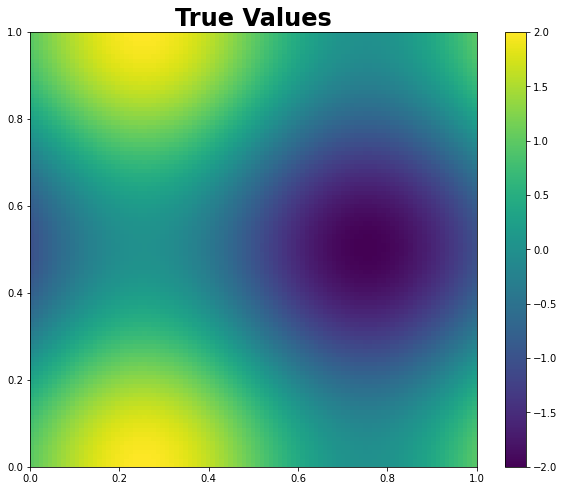

In [4]:
plt.figure(figsize = (10,8))

u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U,V = np.meshgrid(u, v)
Z = np.sin(2*np.pi*U) + np.cos(2*np.pi*V)
plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.title('True Values', fontsize = 24, fontweight = 'bold')
plt.colorbar();

And our training data plotted on top:

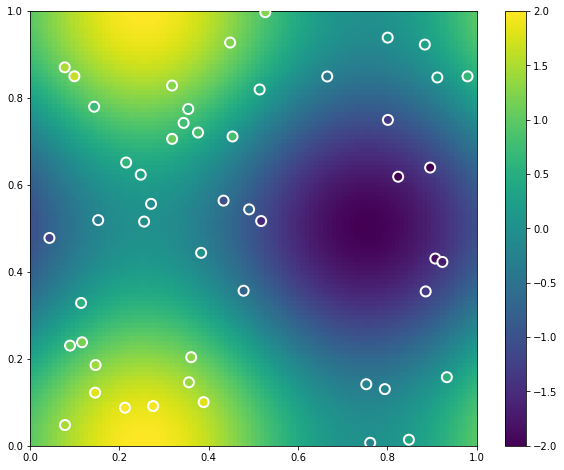

In [5]:
plt.figure(figsize = (10,8))

u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U,V = np.meshgrid(u, v)
Z = np.sin(2*np.pi*U) + np.cos(2*np.pi*V)
plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

The way a decision tree model works is that it looks at all possible ways to split the dataset using a single feature and finds the one that improves the mean squared error obtained by averaging all values observed within the splits generated.

In [6]:
from decision_tree_plot import decision_tree_widget

In [7]:
interact(decision_tree_widget, 
         X = fixed(X), y = fixed(y),
         max_depth = [1,2,3,4,5,6,7,8,9,10,  None], show_prediction = False, show_breaks = False);

interactive(children=(Dropdown(description='max_depth', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None), value=1…

In [8]:
from sklearn.tree import DecisionTreeRegressor

In [9]:
dt = DecisionTreeRegressor(random_state = 321)

In [10]:
dt.fit(X, y)

DecisionTreeRegressor(random_state=321)

In [11]:
from decision_tree_plot import decision_tree_plot

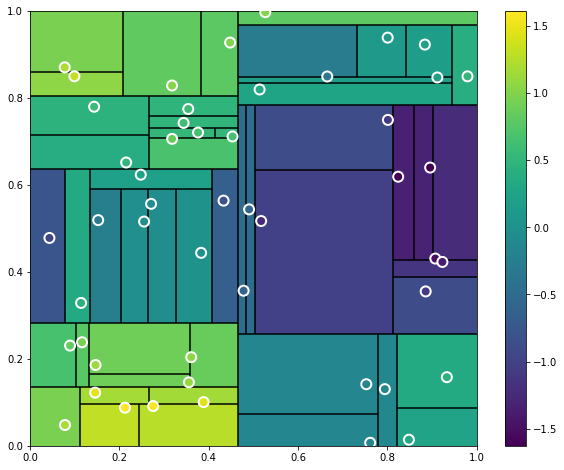

In [12]:
decision_tree_plot(X, y, dt)

Now, let's see how we did it terms of mean squared error.

In [13]:
from sklearn.metrics import mean_squared_error

First, on the training data.

In [14]:
mean_squared_error(y, dt.predict(X))

0.0

It is perfect. It you look, each training data point ended up in its own rectangle.

But what about new data. We'll see how it does on 10000 new points.

In [15]:
X_eval, y_eval = generateData(size = 10000, random_state = 321)

In [16]:
mean_squared_error(y_eval, dt.predict(X_eval))

0.2584891938220013

**Lesson:** Decision trees can be extremely flexible and fit the training data exactly. However, with a model this flexible, there is a great risk of overfitting.

## Decision Trees on the King County Housing Dataset

Now, let's see how well a decision tree regressor can do on the housing dataset we have been working with.

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [22]:
kc = pd.read_csv('../data/kc_house_data.csv')

X = kc[['date', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
y = kc['price']

X['date'] = pd.to_datetime(X['date'])
X['sales_year'] = X['date'].dt.year
X['sales_month'] = X['date'].dt.month

X['age_at_sale'] = X['sales_year'] - X['yr_built']
X['years_since_renovation'] = X['sales_year'] - np.max(X[['yr_built', 'yr_renovated']], axis = 1)

X = X.drop(columns = ['date', 'yr_built', 'yr_renovated'])

X = pd.get_dummies(X, columns = ['zipcode', 'sales_year', 'sales_month'], drop_first = True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [28]:
dt = DecisionTreeRegressor().fit(X_train, y_train)

On the training data, it does extremely well:

In [30]:
mean_squared_error(y_train, dt.predict(X_train))

129.25562958850023

In [32]:
mean_absolute_error(y_train, dt.predict(X_train))

0.12628786476648776

In [33]:
mean_squared_error(y_test, dt.predict(X_test))

38774183026.85622

In [34]:
mean_absolute_error(y_test, dt.predict(X_test))

98780.4009992598

While decision trees don't care about skewness of the predictors (since they only care about the _order_ of the values, we might see some benefit from applying the log to the target. 

In [35]:
dt = DecisionTreeRegressor().fit(X_train, np.log(y_train))

In [37]:
mean_squared_error(y_test, np.exp(dt.predict(X_test)))

34343125501.34794

In [38]:
mean_absolute_error(y_test, np.exp(dt.predict(X_test)))

98209.97925976099

Based on these results, it looks like an out-of-the-box decision tree model is going to severely overfit our dataset.